In [402]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import re
import nltk
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import TreebankWordTokenizer
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

import sklearn
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.preprocessing import Binarizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

import warnings
from wordcloud import STOPWORDS, WordCloud
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Data Extraction and Preprocessing**

In [3]:
!unzip '/content/drive/MyDrive/Datasets Sem-6/IR Datasets/Project/liar_dataset.zip'

Archive:  /content/drive/MyDrive/Datasets Sem-6/IR Datasets/Project/liar_dataset.zip
  inflating: README                  
  inflating: test.tsv                
  inflating: train.tsv               
  inflating: valid.tsv               


In [212]:
train_df = pd.read_csv('/content/train.tsv',sep='\t', header = None)
test_df = pd.read_csv('/content/test.tsv',sep='\t', header = None)
val_df = pd.read_csv('/content/valid.tsv',sep='\t', header = None)

In [213]:
train_df = train_df.drop([0, 8, 9, 10, 11, 12], axis = 1)
test_df = test_df.drop([0, 8, 9, 10, 11, 12], axis = 1)
val_df = val_df.drop([0, 8, 9, 10, 11, 12], axis = 1)

In [214]:
train_df.columns = ['label', 'statement', 'subject', 'speaker', 'speaker job title', 'state info', 'party affilation', 'location of statement']
test_df.columns = ['label', 'statement', 'subject', 'speaker', 'speaker job title', 'state info', 'party affilation', 'location of statement']
val_df.columns = ['label', 'statement', 'subject', 'speaker', 'speaker job title', 'state info', 'party affilation', 'location of statement']

In [215]:
train_df = train_df.dropna()
train_df = train_df.reset_index(drop=True)
test_df = test_df.dropna()
test_df = test_df.reset_index(drop=True)
val_df = val_df.dropna()
val_df = val_df.reset_index(drop=True)

In [216]:
print('Training Data Dimensions -', train_df.shape)
print('Testing Data Dimensions -', test_df.shape)
print('Validation Data Dimensions -', val_df.shape)

Training Data Dimensions - (6724, 8)
Testing Data Dimensions - (853, 8)
Validation Data Dimensions - (861, 8)


**Exploratory Data Analysis**

Text(0.5, 1.0, 'Frequency of different classes in the dataset')

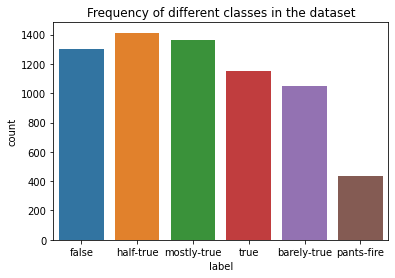

In [108]:
sns.countplot(x='label',data=train_df)
plt.title('Frequency of different classes in the dataset')

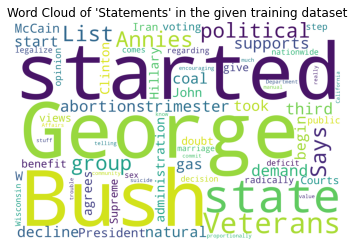

In [109]:
text = train_df['statement'].values
wordcloud = WordCloud(width=3000, height=2000, background_color='white',stopwords=STOPWORDS).generate(str(text))
plt.imshow(wordcloud)
plt.axis('off')
plt.title("Word Cloud of 'Statements' in the given training dataset")
plt.show()

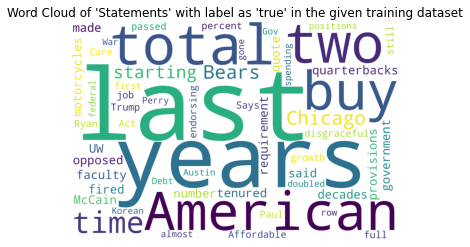

In [110]:
text = train_df[train_df['label'] == 'true']['statement'].values
wordcloud = WordCloud(width=3000, height=2000, background_color='white',stopwords=STOPWORDS).generate(str(text))
plt.imshow(wordcloud)
plt.axis('off')
plt.title("Word Cloud of 'Statements' with label as \'true\' in the given training dataset")
plt.show()

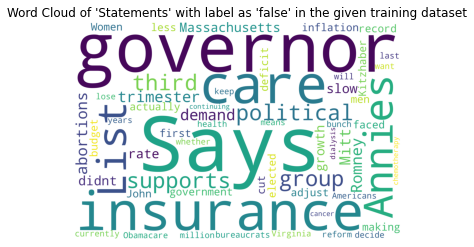

In [111]:
text = train_df[train_df['label'] == 'false']['statement'].values
wordcloud = WordCloud(width=3000, height=2000, background_color='white',stopwords=STOPWORDS).generate(str(text))
plt.imshow(wordcloud)
plt.axis('off')
plt.title("Word Cloud of 'Statements' with label as \'false\' in the given training dataset")
plt.show()

In [112]:
num_unique_speakers = train_df['speaker'].nunique()
avg_statments = len(train_df) / num_unique_speakers

print(f"Unique speakers in dataset: {num_unique_speakers}")
print(f"Average statements made per speaker: {avg_statments}")

Unique speakers in dataset: 1635
Average statements made per speaker: 4.112538226299694


In [113]:
def speaker_bar_chart(input_data, speaker):
  data_df = input_data[input_data['speaker'] == speaker]
  sns.countplot(x='label',data=data_df)
  plt.title('Frequency of different classes for the speaker %s'% speaker)

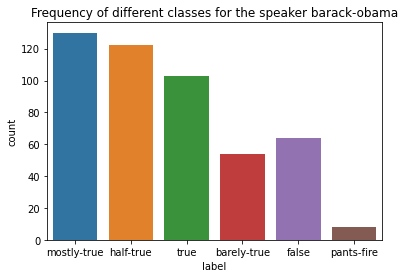

In [114]:
speaker_bar_chart(train_df, 'barack-obama')

**Model Training and Evaluation**

In [217]:
labels_dict = {'mostly-true':4,'barely-true':2,'half-true':3,'false':1, 'true':5,'pants-fire':0}
train_df['label'] = train_df['label'].apply(lambda x: labels_dict[x])
test_df['label'] = test_df['label'].apply(lambda x: labels_dict[x])
val_df['label'] = val_df['label'].apply(lambda x: labels_dict[x])

In [218]:
def preprocess(text):
  text = text.lower() # lower - casing the text
  text = re.sub('<[^>]*>', ' ', text)
  text = re.sub('[\W]+', ' ', text)
  tokenizer = TreebankWordTokenizer()
  words = tokenizer.tokenize(text)
  text = ' '.join(words)
  stop_words = set(stopwords.words('english'))
  word_tokens = word_tokenize(text)
  filtered_sentence = [w for w in word_tokens if not w in stop_words] # removal of stopwords
  text = ' '.join(filtered_sentence)
  ps = PorterStemmer()
  lemmatizer = WordNetLemmatizer()
  stemming = []
  lemmit = []
  for word in text.split():
    stemming.append(ps.stem(word))
  for word in stemming:
    lemmit.append(lemmatizer.lemmatize(word))
  text = ' '.join(lemmit)
  return text

In [219]:
def get_XY(data):
  y = data['label'].values
  data = data['statement'].values
  X = data
  return X,y

In [220]:
X_train, y_train = get_XY(train_df)
X_test, y_test = get_XY(test_df)
X_val, y_val = get_XY(val_df)

In [222]:
def Tokenizer(str_input):
  words = re.sub(r"[^A-Za-z0-9\-]", " ", str_input).lower().split()
  porter_stemmer=nltk.PorterStemmer()
  words = [porter_stemmer.stem(word) for word in words]
  return words
stopwords_list = stopwords.words('english')

**Multinomial Naive Bayes on the matrix of token counts (Count Vectorizer)**

In [399]:
model1 = Pipeline([
    ('vectorizer', CountVectorizer(analyzer='word',preprocessor=preprocess,tokenizer=Tokenizer,stop_words=stopwords_list, ngram_range=(1,2))),
    ('selector', SelectKBest(chi2, k=1500)),
    ('clf', MultinomialNB()),
])

In [400]:
model1.fit(X_train, y_train)
test_preds = model1.predict(X_test)
val_preds = model1.predict(X_val)

In [401]:
print(classification_report(y_test, test_preds))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        43
           1       0.23      0.28      0.25       167
           2       0.29      0.09      0.13       139
           3       0.20      0.36      0.25       182
           4       0.26      0.33      0.29       173
           5       0.21      0.07      0.11       149

    accuracy                           0.23       853
   macro avg       0.20      0.19      0.17       853
weighted avg       0.22      0.23      0.20       853



**Logistic Regression on the normalized matrix of token counts (TFID Vectorizer)**

In [349]:
model2 = Pipeline([
    ('vectorizer', TfidfVectorizer(analyzer='word',preprocessor=preprocess,tokenizer=Tokenizer,stop_words=stopwords_list)),
    ('selector', SelectKBest(chi2, k=1500)),
    ('clf', LogisticRegression()),
])

In [350]:
model2.fit(X_train, y_train)
test_preds = model2.predict(X_test)
val_preds = model2.predict(X_val)

In [351]:
print(classification_report(y_test, test_preds))

              precision    recall  f1-score   support

           0       0.50      0.02      0.04        43
           1       0.31      0.41      0.35       167
           2       0.34      0.16      0.22       139
           3       0.23      0.31      0.27       182
           4       0.26      0.30      0.28       173
           5       0.21      0.17      0.19       149

    accuracy                           0.26       853
   macro avg       0.31      0.23      0.22       853
weighted avg       0.28      0.26      0.25       853



In [355]:
model3 = Pipeline([
    ('vectorizer', CountVectorizer(analyzer='word',preprocessor=preprocess,tokenizer=Tokenizer,stop_words=stopwords_list, ngram_range=(1,3))),
    ('norm', Binarizer()),
    ('clf', LogisticRegression(solver = 'liblinear')),
])

In [356]:
model3.fit(X_train, y_train)
test_preds = model3.predict(X_test)
val_preds = model3.predict(X_val)

In [357]:
print(classification_report(y_test, test_preds))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        43
           1       0.28      0.35      0.31       167
           2       0.24      0.15      0.19       139
           3       0.27      0.29      0.28       182
           4       0.22      0.26      0.24       173
           5       0.23      0.22      0.22       149

    accuracy                           0.25       853
   macro avg       0.20      0.21      0.21       853
weighted avg       0.23      0.25      0.24       853



**Support Vector Machines**

In [337]:
model4 = Pipeline([
    ('vectorizer', TfidfVectorizer(analyzer='word',preprocessor=preprocess,tokenizer=Tokenizer,stop_words=stopwords_list)),
    ('norm', Binarizer()),
    ('clf', SVC()),
])

In [338]:
model4.fit(X_train, y_train)
test_preds = model4.predict(X_test)
val_preds = model4.predict(X_val)

In [339]:
print(classification_report(y_test, test_preds))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        43
           1       0.29      0.48      0.36       167
           2       0.28      0.06      0.11       139
           3       0.27      0.38      0.32       182
           4       0.25      0.31      0.28       173
           5       0.23      0.12      0.16       149

    accuracy                           0.27       853
   macro avg       0.22      0.23      0.20       853
weighted avg       0.25      0.27      0.24       853



**Decision Tree Classifier**

In [340]:
model5 = Pipeline([
    ('vectorizer', CountVectorizer(analyzer='word',preprocessor=preprocess,tokenizer=Tokenizer,stop_words=stopwords_list)),
    ('selector', SelectKBest(chi2, k=2000)),
    ('clf', DecisionTreeClassifier()),
])

In [341]:
model5.fit(X_train, y_train)
test_preds = model5.predict(X_test)
val_preds = model5.predict(X_val)

In [342]:
print(classification_report(y_test, test_preds))

              precision    recall  f1-score   support

           0       0.09      0.07      0.08        43
           1       0.25      0.29      0.27       167
           2       0.22      0.19      0.20       139
           3       0.24      0.24      0.24       182
           4       0.24      0.28      0.26       173
           5       0.21      0.18      0.19       149

    accuracy                           0.23       853
   macro avg       0.21      0.21      0.21       853
weighted avg       0.23      0.23      0.23       853



**Random Forest**

In [403]:
model6 = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('clf', RandomForestClassifier(n_estimators=1000, random_state=42)),
])

In [404]:
model6.fit(X_train, y_train)
test_preds = model6.predict(X_test)
val_preds = model6.predict(X_val)

In [405]:
print(classification_report(y_test, test_preds))

              precision    recall  f1-score   support

           0       1.00      0.02      0.05        43
           1       0.25      0.40      0.31       167
           2       0.27      0.11      0.15       139
           3       0.25      0.32      0.28       182
           4       0.23      0.31      0.27       173
           5       0.22      0.11      0.15       149

    accuracy                           0.25       853
   macro avg       0.37      0.21      0.20       853
weighted avg       0.28      0.25      0.23       853

